# Group Assignment Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import matplotlib.font_manager
from sqlalchemy import create_engine
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load csv file as DataFrame
df = pd.read_csv('pizza_sales.csv')


## Step 1 - High level EDA (Exploratory Data Analysis)

## Step 2 - Feature Engineering: Cleaning and preparing the features

In [2]:
# --------------------- DATA CLEANING: 'order_date' column -----------------

# Convert the order_date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

In [3]:
# --------------------- DATA CLEANING: 'pizza_name' column -----------------

# Remove the word "Pizza" from the pizza_name column
df['pizza_name'] = df['pizza_name'].str.replace('Pizza','')

In [4]:
# --------------------- DATA CLEANING - Outliers dropping -----------------

# Drop pizza_size of XL and XXL
df = df[~df['pizza_size'].isin(['XL', 'XXL'])]

In [5]:
# --------------------- DATA CLEANING - Dropping unecessary columns -----------------
df = df[['order_date', 'pizza_name', 'quantity']]

In [6]:
# --------------------- FEATURE ENGINEERING - Modifying "quantity" column -----------------

# Create a column that sums the quantity of pizzas hour of day and pizza_name
df['quantity'] = df.groupby(['order_date', 'pizza_name'])['quantity'].transform('sum')

In [7]:
# --------------------- FEATURE ENGINEERING - Creating new features -----------------

# Create a column with the day of week number
df['order_dayOfWeek'] = df['order_date'].dt.dayofweek

# Create a column with the day of month number
df['order_dayOfMonth'] = df['order_date'].dt.day

# Create a column with month number
df['order_month'] = df['order_date'].dt.month

In [8]:
# --------------------- FEATURE ENGINEERING - Deleting duplicates -----------------
df = df.drop_duplicates()

In [9]:
# --------------------- FEATURE ENGINEERING - Creating lag features -----------------
df['quantity_lag1'] = df['quantity'].shift(1)
df['quantity_lag2'] = df['quantity'].shift(2)
df['quantity_lag3'] = df['quantity'].shift(3)
df['quantity_lag4'] = df['quantity'].shift(4)
df['quantity_lag5'] = df['quantity'].shift(5)
df['quantity_lag6'] = df['quantity'].shift(6)
df['quantity_lag7'] = df['quantity'].shift(7)
df['quantity_lag8'] = df['quantity'].shift(8)
df['quantity_lag9'] = df['quantity'].shift(9)
df['quantity_lag10'] = df['quantity'].shift(10)
df['quantity_lag11'] = df['quantity'].shift(11)
df['quantity_lag12'] = df['quantity'].shift(12)
df['quantity_lag13'] = df['quantity'].shift(13)
df['quantity_lag14'] = df['quantity'].shift(14)

In [10]:
# Select only the rows that have the pizza_name 'The Hawaiian'
filtered_df = df[df['pizza_name'] == 'The Hawaiian ']

In [11]:
filtered_df.head()

,order_date,pizza_name,quantity,order_dayOfWeek,order_dayOfMonth,order_month,quantity_lag1,quantity_lag2,quantity_lag3,quantity_lag4,quantity_lag5,quantity_lag6,quantity_lag7,quantity_lag8,quantity_lag9,quantity_lag10,quantity_lag11,quantity_lag12,quantity_lag13,quantity_lag14
0,2015-01-01,The Hawaiian,4,3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,2015-01-02,The Hawaiian,10,4,2,1,8.0,6.0,1.0,8.0,8.0,2.0,5.0,6.0,4.0,9.0,4.0,4.0,6.0,2.0
335,2015-01-03,The Hawaiian,8,5,3,1,1.0,5.0,7.0,7.0,4.0,7.0,3.0,7.0,12.0,4.0,8.0,3.0,1.0,1.0
504,2015-01-04,The Hawaiian,4,6,4,1,4.0,3.0,3.0,2.0,5.0,4.0,3.0,4.0,11.0,4.0,5.0,5.0,5.0,6.0
583,2015-01-05,The Hawaiian,5,0,5,1,2.0,6.0,2.0,1.0,1.0,2.0,4.0,1.0,5.0,3.0,1.0,4.0,4.0,4.0


## Step 3 - Database creation with SQLite: Create "pizza_sales" database

In [12]:
# Define the SQLite database URI and create the database engine
db_uri = "sqlite:///pizza_sales.db"
engine = create_engine(db_uri)

# Save "sales_data" table in the database, containing the whole dataframe
filtered_df.to_sql('full_sales_data', engine, if_exists='replace', index=False)

# Save "features" table in the database, containing only the X columns/features
features_df = filtered_df[['order_dayOfWeek', 'order_dayOfMonth', 'order_month']]
features_df.to_sql('features', engine, if_exists='replace', index=False)

# Save "quantities" table in the database, containing only the Y column/feature
y_df = filtered_df['quantity']
y_df.to_sql('quantities', engine, if_exists='replace', index=False)

358

## Step 4 - Splitting the dataset

In [13]:
df = pd.read_sql('full_sales_data', engine)

X = df.drop(['order_date','pizza_name'], axis=1)
y = df['quantity']

In [14]:
# Split the data
test_index = df["order_date"].iloc[-1] - pd.DateOffset(months=6)
X_train, X_test = X.loc[df['order_date'] < test_index], X.loc[df['order_date'] >= test_index]
y_train, y_test = y.loc[df['order_date'] < test_index], y.loc[df['order_date'] >= test_index]
test_dates = df.loc[df['order_date'] >= test_index, 'order_date']

## Step 5 - Model training and validation

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'n_estimators': np.arange(50, 250, 10),
    'max_depth': np.arange(5, 20, 2)
}

rf = RandomForestRegressor(random_state=42)

grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=15,
                                 cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'n_estimators': 90, 'max_depth': 5}
Best score: -0.4899624061735584


## Step 6 - Model evaluation

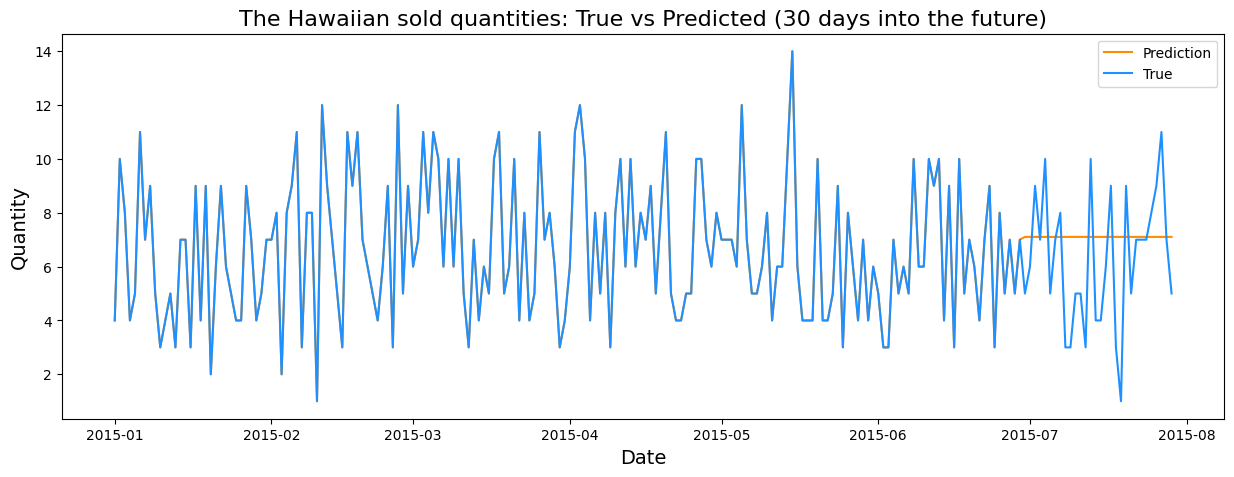

In [16]:
import warnings
warnings.filterwarnings("ignore")


def predict_next_quantity(X, model, n_periods):
    X_pred = X.copy()
    y_pred = np.zeros(n_periods)
    for i in range(n_periods):
        X_pred = pd.concat([X_pred, X_pred.iloc[-1:, :]], axis=0, ignore_index=True)
        y_pred[i] = model.predict(X_pred.iloc[-1:])
        X_pred['quantity_lag1'].iloc[-1] = y_pred[i]
        X_pred['quantity_lag2'].iloc[-1] = X_pred['quantity_lag1'].iloc[-1]
        X_pred['quantity_lag3'].iloc[-1] = X_pred['quantity_lag2'].iloc[-1]
        X_pred['quantity_lag4'].iloc[-1] = X_pred['quantity_lag3'].iloc[-1]
        X_pred['quantity_lag5'].iloc[-1] = X_pred['quantity_lag4'].iloc[-1]
        X_pred['quantity_lag6'].iloc[-1] = X_pred['quantity_lag5'].iloc[-1]
        X_pred['quantity_lag7'].iloc[-1] = X_pred['quantity_lag6'].iloc[-1]
        X_pred['quantity_lag8'].iloc[-1] = X_pred['quantity_lag7'].iloc[-1]
        X_pred['quantity_lag9'].iloc[-1] = X_pred['quantity_lag8'].iloc[-1]
        X_pred['quantity_lag10'].iloc[-1] = X_pred['quantity_lag9'].iloc[-1]
        X_pred['quantity_lag11'].iloc[-1] = X_pred['quantity_lag10'].iloc[-1]
        X_pred['quantity_lag12'].iloc[-1] = X_pred['quantity_lag11'].iloc[-1]
        X_pred['quantity_lag13'].iloc[-1] = X_pred['quantity_lag12'].iloc[-1]
        X_pred['quantity_lag14'].iloc[-1] = X_pred['quantity_lag13'].iloc[-1]
    return X_pred, y_pred

model = grid_search.best_estimator_

# Predict the next 30 days
X_pred, y_pred = predict_next_quantity(X_train, model, n_periods=30)

# Concatenate the predictions to the original dataframe
y_pred = pd.concat([y_train, pd.Series(y_pred)], axis=0)
y_true = pd.concat([y_train, y_test.iloc[0:30]], axis=0)
time = pd.concat([df.loc[df['order_date'] < test_index, 'order_date'], test_dates.iloc[0:30]], axis=0)

# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time, y_pred, label='Prediction', color='darkorange')
ax.plot(time, y_true, label='True', color='dodgerblue')
ax.set_title('The Hawaiian sold quantities: True vs Predicted (30 days into the future)', fontsize=16)
ax.set_ylabel('Quantity', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.legend()
plt.show()

## Step 7 - Saving the model to a file

In [17]:
from joblib import dump, load

# Assuming best_rf_model_GS is your trained model
dump(model, 'best_pizza_model.joblib')


['best_pizza_model.joblib']